In [1]:
import importlib.util
import subprocess

# Lista de paquetes que queremos instalar si no están presentes
packages = [
    "openmeteo-requests",
    "requests-cache",
    "retry-requests",
    "numpy",
    "pandas",
    "ydata-profiling",
    "skforecast"
]

# Función para verificar e instalar paquetes
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Instalando {package}...")
        subprocess.check_call(["pip", "install", package])
    else:
        print(f"{package} ya está instalado.")

# Iterar sobre la lista de paquetes
for package in packages:
    install_if_missing(package)

Instalando openmeteo-requests...
Instalando requests-cache...
Instalando retry-requests...
numpy ya está instalado.
pandas ya está instalado.
Instalando ydata-profiling...
Instalando skforecast...


In [2]:
# Importamos las librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Importamos librerías para visualización
from seaborn import heatmap
from matplotlib import pyplot as plt

# Análisis y estadísticas
from ydata_profiling import ProfileReport
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox

# Machine Learning y preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Forecasting con Skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster

# SHAP para interpretabilidad de modelos
import shap




##Proyección de las variables a futuro

Vamos a realizar un proceso de predicción  de varios años del la generacion neta de cada planta y la capacidad maxima en verano, que son las variables que nos indican mas evolución en la eficiencia y tecnologia de dichas plantas, y ver si tienen una mejora considerable o no


Dado que las variables parecen tener un crecimiento lineal y "predecible", sin relaciones muy complicadas una regresion lineal deberia ser suficiente para un moedelo sencillo

Tambien vamos a probar con el SARIMAX, que no es un modelo de machine learning como tal, si no un modelo estadistico, que podria ser util, e incluso podriamos hacer uso de los datos generados por SARIMAX para el modelo de machine learning

Vamos a probar con una regresion lineal y una regresion polinómica de bajo grado para ver como evoluciona la tendencia de ambas variables

In [3]:
#realizamos la carga de archivos
monthly_data_per_unit = pd.read_excel('/content/monthly_data_per_unit.xlsx')
monthly_data_suavizado = pd.read_excel('/content/monthly_data_suavizado.xlsx')
monthly_data_per_unit.set_index('Date', inplace=True)
monthly_data_suavizado.set_index('Date', inplace=True)
monthly_data_suavizado.tail(),monthly_data_per_unit.head()

(            Net_Summer_Capacity_MW  Net_Generation_MWh  \
 Date                                                     
 2024-07-01                1.030385          701.947037   
 2024-08-01                1.030460          701.296385   
 2024-09-01                1.030536          698.100511   
 2024-10-01                1.030611          694.856183   
 2024-11-01                1.030686          693.948877   
 
             Share_of_Electricity_Percent  Capacity_Factor_Percent  
 Date                                                               
 2024-07-01                      0.197976                 0.998627  
 2024-08-01                      0.197819                 0.996719  
 2024-09-01                      0.196936                 0.991202  
 2024-10-01                      0.195605                 0.986213  
 2024-11-01                      0.195154                 0.984023  ,
             Net_Summer_Capacity_MW  Net_Generation_MWh  \
 Date                                     

In [4]:


#Vamos a calcular si hay mucha colinealidad en las variables para ver si podemos excluir alguna
# Seleccionar las variables independientes (excluyendo Net Generation, ya que es la variable dependiente)
X = monthly_data_per_unit.drop(columns=["Net_Generation_MWh"])

# Añadir una columna de unos para la intersección (sesgo del modelo)
X = X.assign(const=1)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,Variable,VIF
0,Net_Summer_Capacity_MW,2.395021
1,Share_of_Electricity_Percent,1.288431
2,Capacity_Factor_Percent,2.430112
3,const,1188.871400


In [5]:
def escalar_xy(data, variables_exogenas):
    """
    Escala las variables exógenas y extrae la variable dependiente del conjunto de datos proporcionado.

    Parámetros:
    - data (pd.DataFrame): DataFrame con los datos originales, debe contener las columnas necesarias.
    - variables_exogenas (list): Lista de nombres de las variables exógenas a escalar.

    Retorna:
    - X_escalado (pd.DataFrame): DataFrame con las variables exógenas escaladas.
    - Y_data (pd.Series): Serie con la variable dependiente "Net_Generation_MWh".
    - scalers (dict): Diccionario con los `StandardScaler()` usados para cada variable.
    """
    scalers = {}  # Diccionario para almacenar los scalers

    # Extraer y escalar cada variable exógena individualmente
    X_escalado = pd.DataFrame(index=data.index)

    for col in variables_exogenas:
        scaler = StandardScaler()
        X_escalado[col] = scaler.fit_transform(data[[col]])  # Escalar la columna
        scalers[col] = scaler  # Guardar el scaler usado

    # Convertir la fecha en variable numérica (YYYYMM)
    X_escalado["Date"] = data.index.year * 100 + data.index.month

    # Resetear el índice para evitar problemas
    X_escalado.reset_index(drop=True, inplace=True)

    # Seleccionar la variable dependiente
    Y_data = data["Net_Generation_MWh"].reset_index(drop=True)

    return X_escalado, Y_data, scalers


In [6]:
variables_exogenas = ["Share_of_Electricity_Percent", "Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]
X_escalado,Y_data,scalers =escalar_xy(monthly_data_per_unit,variables_exogenas)
#X_escalado.head(),Y_data.head()
scalers

{'Share_of_Electricity_Percent': StandardScaler(),
 'Capacity_Factor_Percent': StandardScaler(),
 'Net_Summer_Capacity_MW': StandardScaler()}

##Modelo SARIMAX

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Definir el tamaño del conjunto de entrenamiento (80% de los datos)
train_size = int(len(Y_data) * 0.8)

# Dividir datos en entrenamiento y prueba
train, test = Y_data.iloc[:train_size], Y_data.iloc[train_size:] #Seleccionamos primeros como train y ultimos como test

# Ajustar el modelo SARIMAX solo con los datos de entrenamiento
model_sarimax = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model_sarimax.fit(disp=0)

# Predecir en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular métricas de error
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
msape = np.mean(np.abs((test - predictions) / (np.abs(test) + np.abs(predictions))) * 200)  # Mean Symmetric APE


# Mostrar resultados
print(f"La Media de los datos es: {Y_data.mean()}")
print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"MSAPE (Error Porcentual Medio Simétrico): {msape:.2f}%")

La Media de los datos es: 632.8987256987153
MAE (Error Absoluto Medio): 10.03
MSE (Error Cuadrático Medio): 189.83
RMSE (Raíz del Error Cuadrático Medio): 13.78
MSAPE (Error Porcentual Medio Simétrico): 1.46%


Tiene un ajuste bastante bueno

In [8]:
#Ahora hacemos lo mismo pero entrenamos con todos los datos y predecimos a 20 años

import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
n=240 #(20 años)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

model_sarimax = SARIMAX(Y_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model_sarimax.fit(disp=0)
prediction = model_fit.forecast(steps=n)
print(prediction.head())

360    740.770921
361    754.638550
362    669.610714
363    674.222538
364    611.326530
Name: predicted_mean, dtype: float64


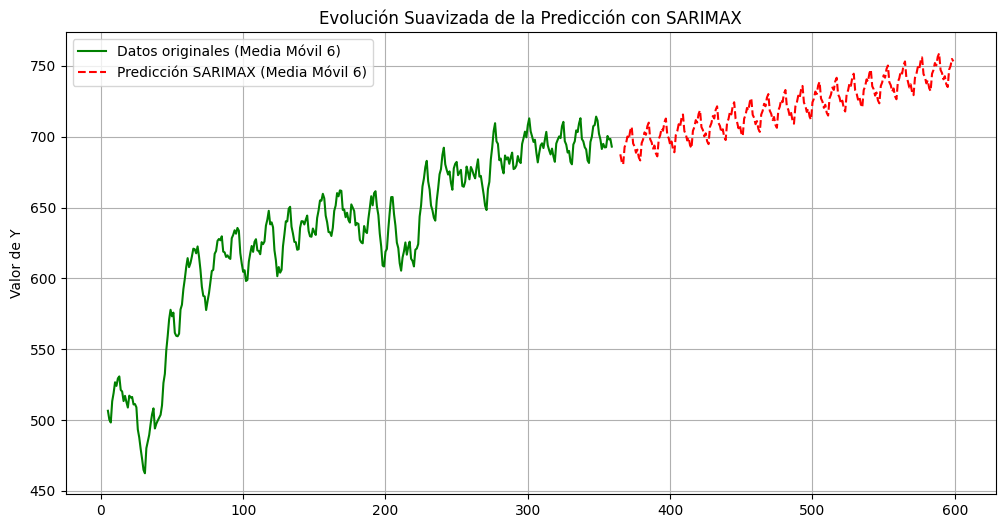

In [9]:
import matplotlib.pyplot as plt

# Definir ventana para la media móvil (por ejemplo, 6 meses)
window_size = 6
# Calcular la media móvil de los datos originales
Y_data_smooth = Y_data.rolling(window_size).mean()

# Calcular la media móvil de la predicción
prediction_smooth = prediction.rolling(window_size).mean()

# Graficar los datos originales suavizados para mejor vista del ajuste
plt.figure(figsize=(12, 6))
plt.plot(Y_data.index, Y_data_smooth, label=f'Datos originales (Media Móvil {window_size})', color='green')

# Graficar la predicción suavizada
plt.plot(prediction.index, prediction_smooth, label=f'Predicción SARIMAX (Media Móvil {window_size})', color='red', linestyle='dashed')

# Etiquetas y título
#plt.xlabel('Fecha')
plt.ylabel('Valor de Y')
plt.title('Evolución Suavizada de la Predicción con SARIMAX')
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

In [10]:
#Ahora realizamosel mismo ajuste para hacer el forecasting con la regresion lineal

variables_exogenas = ["Share_of_Electricity_Percent", "Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]
X_escalado,Y_data,scaler =escalar_xy(monthly_data_per_unit,variables_exogenas)
X_copy_forecasting = X_escalado.copy()
X_copy_forecasting['Date'] = pd.to_datetime(X_copy_forecasting['Date'], format='%Y%m')
X_copy_forecasting.set_index('Date', inplace=True)
Y_copy_forecasting = Y_data.copy()
Y_copy_forecasting.index = X_copy_forecasting.index
X_copy_forecasting.head(),Y_copy_forecasting.head()

(            Share_of_Electricity_Percent  Capacity_Factor_Percent  \
 Date                                                                
 1994-12-01                      0.932479                -1.184454   
 1995-01-01                      1.060166                -0.841658   
 1995-02-01                     -0.216701                -1.553620   
 1995-03-01                     -0.663605                -2.212844   
 1995-04-01                     -0.472075                -2.309530   
 
             Net_Summer_Capacity_MW  
 Date                                
 1994-12-01               -1.898114  
 1995-01-01               -1.898114  
 1995-02-01               -1.898114  
 1995-03-01               -1.898114  
 1995-04-01               -1.898114  ,
 Date
 1994-12-01    555.018349
 1995-01-01    581.119266
 1995-02-01    475.761468
 1995-03-01    475.963303
 1995-04-01    452.486239
 Name: Net_Generation_MWh, dtype: float64)

In [11]:
def evaluar_modelo(y_real, y_pred, metodo):
    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    r2 = r2_score(y_real, y_pred)
    mae_relativo = (mae / np.mean(y_real)) * 100

    print(f"📊 {metodo} - Evaluación en datos de prueba:")
    print(f"   MAE  -> {mae:.2f}")
    print(f"   RMSE -> {rmse:.2f}")
    print(f"   R²   -> {r2:.4f}\n")
    print(f"   MAE Relativo -> {mae_relativo:.2f}%\n")

    return mae_relativo, rmse, r2, mae

In [12]:
Y_copy_forecasting = monthly_data_per_unit["Net_Generation_MWh"].copy()
Y_copy_forecasting.index = X_copy_forecasting.index
Y_copy_forecasting.head()

,Net_Generation_MWh
Date,
1994-12-01,555.018349
1995-01-01,581.119266
1995-02-01,475.761468
1995-03-01,475.963303
1995-04-01,452.486239


In [13]:


# 1️⃣ **Preprocesamiento y selección de datos**
Y_copy_forecasting = Y_copy_forecasting.asfreq('MS')  # Asegurar frecuencia mensual
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y_copy_forecasting.values.reshape(-1, 1)).flatten()

# Convertir en Serie
Y_data_scaled = pd.Series(Y_scaled, index=Y_copy_forecasting.index)

# 2️⃣ **Dividir en conjunto de entrenamiento (80%) y prueba (20%)**
split_idx = int(len(Y_data_scaled) * 0.8)  # 80% para entrenamiento
Y_train = Y_data_scaled[:split_idx]
Y_test = Y_data_scaled[split_idx:]

# 3️⃣ **Definir parámetros de predicción**
lags = [6, 12, 24]  # Usaremos rezagos de 6, 12 y 24 meses
steps = len(Y_test)  # Queremos predecir el 20% final (mismo tamaño que el test)

# 4️⃣ **Definir modelos**
model_ridge = Ridge()

# 🔸 **Método Recursivo**
forecaster_recursive = ForecasterRecursive(
    regressor=model_ridge,
    lags=lags
)
forecaster_recursive.fit(Y_train)
pred_recursive = forecaster_recursive.predict(steps=steps)

# 🔸 **Método Directo**
forecaster_direct = ForecasterDirect(
    regressor=model_ridge,
    steps=steps,
    lags=lags
)
forecaster_direct.fit(Y_train)
pred_direct = forecaster_direct.predict()

# 5️⃣ **Desescalar predicciones**
pred_recursive = scaler.inverse_transform(pred_recursive.values.reshape(-1, 1)).flatten()
pred_direct = scaler.inverse_transform(pred_direct.values.reshape(-1, 1)).flatten()
Y_test_real = scaler.inverse_transform(Y_test.values.reshape(-1, 1)).flatten()  # Desescalar Y_test

# 6️⃣ **Evaluación con métricas**


# Evaluar ambos métodos en test set
evaluar_modelo(Y_test_real, pred_recursive, "Método Recursivo")
evaluar_modelo(Y_test_real, pred_direct, "Método Directo")


📊 Método Recursivo - Evaluación en datos de prueba:
   MAE  -> 16.64
   RMSE -> 20.95
   R²   -> 0.7876

   MAE Relativo -> 2.39%

📊 Método Directo - Evaluación en datos de prueba:
   MAE  -> 44.83
   RMSE -> 56.07
   R²   -> -0.5210

   MAE Relativo -> 6.44%



(6.444795295951666, 56.0744983685914, -0.5210303031826227, 44.82585610356122)

In [14]:
Y_copy_forecasting = monthly_data_per_unit["Net_Generation_MWh"].copy()
Y_copy_forecasting.index = X_copy_forecasting.index
Y_copy_forecasting.head()

,Net_Generation_MWh
Date,
1994-12-01,555.018349
1995-01-01,581.119266
1995-02-01,475.761468
1995-03-01,475.963303
1995-04-01,452.486239


In [15]:
# Variable para controlar la ejecución del GridSearch
ejecutar = False

if ejecutar:
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import Ridge
    from sklearn.ensemble import GradientBoostingRegressor

    # 1️⃣ GridSearch para Ridge Regression
    param_grid_ridge = {'alpha': [1e-05, 1e-06, 1e-07, 1e-10]}
    ridge = Ridge()

    grid_search_ridge = GridSearchCV(
        estimator=ridge,
        param_grid=param_grid_ridge,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    grid_search_ridge.fit(Y_copy_forecasting.values.reshape(-1, 1), Y_copy_forecasting.values)

    best_ridge_model = grid_search_ridge.best_estimator_
    best_alpha = grid_search_ridge.best_params_['alpha']

    # 2️⃣ GridSearch para GradientBoosting
    param_grid_gb = {
        'n_estimators': [325, 350, 375, 400],
        'learning_rate': [0.2, 0.3, 0.4],
        'max_depth': [5, 7, 9]
    }

    gb = GradientBoostingRegressor()

    grid_search_gb = GridSearchCV(
        estimator=gb,
        param_grid=param_grid_gb,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    grid_search_gb.fit(Y_copy_forecasting.values.reshape(-1, 1), Y_copy_forecasting.values)

    best_gb_model = grid_search_gb.best_estimator_
    best_params_gb = grid_search_gb.best_params_

    # Mostrar resultados
    best_alpha, best_ridge_model, best_params_gb, best_gb_model
else:
    print("⚠️ La ejecución de GridSearch está desactivada. Cambia 'ejecutar' a True para ejecutarlo.")


⚠️ La ejecución de GridSearch está desactivada. Cambia 'ejecutar' a True para ejecutarlo.


In [69]:
from skforecast.direct import ForecasterDirect  # Changed import statement
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

metricas_recursive = {}
metricas_direct = {}

# 1️⃣ **Preprocesamiento y selección de datos**
Y_copy_forecasting = Y_copy_forecasting.asfreq('MS')  # Asegurar frecuencia mensual
print(Y_copy_forecasting.head())
#scaler = StandardScaler()
#Y_scaled = scaler.fit_transform(Y_copy_forecasting.values.reshape(-1, 1)).flatten()

# Convertir en Serie
#Y_data_scaled = pd.Series(Y_scaled, index=Y_copy_forecasting.index)
Y_data_scaled = pd.Series(Y_copy_forecasting.values, index=Y_copy_forecasting.index)
print(Y_data_scaled.head())

# 2️⃣ **Dividir en conjunto de entrenamiento (80%) y prueba (20%)**
split_idx = int(len(Y_data_scaled) * 0.8)  # 80% para entrenamiento
Y_train = Y_data_scaled[:split_idx]
print(Y_train.head())
Y_test = Y_data_scaled[split_idx:]
print(Y_test.head())

# 3️⃣ **Definir parámetros de predicción**
lags = np.arange(1,35)
steps = len(Y_test)  # Queremos predecir el 20% final (mismo tamaño que el test)


# 4️⃣ **Definir modelos* (dejamos solo ridge y gradientboosting son los que mejor se ajustan)
#Tras hacer el grid no parece realmente afectar con diferentes parmetros a la precisiond el ajuste, dejamos los predeterminados
modelos = {
    "Ridge": Ridge(),#alpha=0.001
    "GradientBoosting": GradientBoostingRegressor()#learning_rate=0.3, max_depth=7, n_estimators=300
    #"MLP": MLPRegressor(),
    #"SVR": SVR()
}

for model in modelos:
  #metodo recursivo
  forecaster_recursive = ForecasterRecursive(
      regressor=modelos[model],
      lags=lags
  )
  forecaster_recursive.fit(Y_train)
  pred_recursive = forecaster_recursive.predict(steps=steps)
  ajuste_recursive = evaluar_modelo(Y_test, pred_recursive, f"Método Recursivo - {model}")

  forecaster_direct = ForecasterDirect(
      regressor=modelos[model],
      steps=steps,
      lags=lags
  )
  forecaster_direct.fit(Y_train)
  pred_direct = forecaster_direct.predict(steps)
  ajuste_direct = evaluar_modelo(Y_test, pred_direct, f"Método Directo - {model}")




Date
1994-12-01    555.018349
1995-01-01    581.119266
1995-02-01    475.761468
1995-03-01    475.963303
1995-04-01    452.486239
Freq: MS, Name: Net_Generation_MWh, dtype: float64
Date
1994-12-01    555.018349
1995-01-01    581.119266
1995-02-01    475.761468
1995-03-01    475.963303
1995-04-01    452.486239
Freq: MS, dtype: float64
Date
1994-12-01    555.018349
1995-01-01    581.119266
1995-02-01    475.761468
1995-03-01    475.963303
1995-04-01    452.486239
Freq: MS, dtype: float64
Date
2018-12-01    731.193878
2019-01-01    752.051020
2019-02-01    660.357143
2019-03-01    664.081633
2019-04-01    618.173469
Freq: MS, dtype: float64
📊 Método Recursivo - Ridge - Evaluación en datos de prueba:
   MAE  -> 27.14
   RMSE -> 30.58
   R²   -> 0.5478

   MAE Relativo -> 3.90%

📊 Método Directo - Ridge - Evaluación en datos de prueba:
   MAE  -> 34.74
   RMSE -> 37.82
   R²   -> 0.3082

   MAE Relativo -> 5.00%

📊 Método Recursivo - GradientBoosting - Evaluación en datos de prueba:
   MAE 

In [68]:
import pandas as pd

# Diccionarios para almacenar predicciones y métricas
pred_recursive_dict = {}
pred_direct_dict = {}
metricas_dict = {"Modelo": [], "Método": [], "MAE": [], "RMSE": [], "R²": [], "MAE Relativo": []}

# Iterar sobre los modelos y guardar resultados en los diccionarios
for model_name, model in modelos.items():
    # Método Recursivo
    forecaster_recursive = ForecasterRecursive(regressor=model, lags=lags)
    forecaster_recursive.fit(Y_train)
    pred_recursive = forecaster_recursive.predict(steps=steps)
    pred_recursive_dict[model_name] = pred_recursive

    # Evaluar modelo recursivo
    mae_rel, rmse, r2, mae = evaluar_modelo(Y_test, pred_recursive, f"Método Recursivo - {model_name}")
    metricas_dict["Modelo"].append(model_name)
    metricas_dict["Método"].append("Recursivo")
    metricas_dict["MAE"].append(mae)
    metricas_dict["RMSE"].append(rmse)
    metricas_dict["R²"].append(r2)
    metricas_dict["MAE Relativo"].append(mae_rel)

    # Método Directo
    forecaster_direct = ForecasterDirect(regressor=model, steps=steps, lags=np.arange(1,35))
    forecaster_direct.fit(Y_train)
    pred_direct = forecaster_direct.predict(steps=steps)
    pred_direct_dict[model_name] = pred_direct

    # Evaluar modelo directo
    mae_rel, rmse, r2, mae = evaluar_modelo(Y_test, pred_direct, f"Método Directo - {model_name}")
    metricas_dict["Modelo"].append(model_name)
    metricas_dict["Método"].append("Directo")
    metricas_dict["MAE"].append(mae)
    metricas_dict["RMSE"].append(rmse)
    metricas_dict["R²"].append(r2)
    metricas_dict["MAE Relativo"].append(mae_rel)

# Convertir predicciones a DataFrame
df_predicciones_recursivas = pd.DataFrame(pred_recursive_dict)
df_predicciones_directas = pd.DataFrame(pred_direct_dict)

# Asegurar que los índices coinciden con Y_test
df_predicciones_recursivas.index = Y_test.index
df_predicciones_directas.index = Y_test.index



# Convertir métricas a DataFrame
df_metricas = pd.DataFrame(metricas_dict)
# Separar métricas por método (Recursivo y Directo)
df_metricas_recursivas = df_metricas[df_metricas["Método"] == "Recursivo"].reset_index(drop=True)
df_metricas_directas = df_metricas[df_metricas["Método"] == "Directo"].reset_index(drop=True)

# Mostrar DataFrames al usuario
df_metricas_recursivas, df_metricas_directas, df_predicciones_recursivas, df_predicciones_directas


AttributeError: 'dict' object has no attribute 'fit'

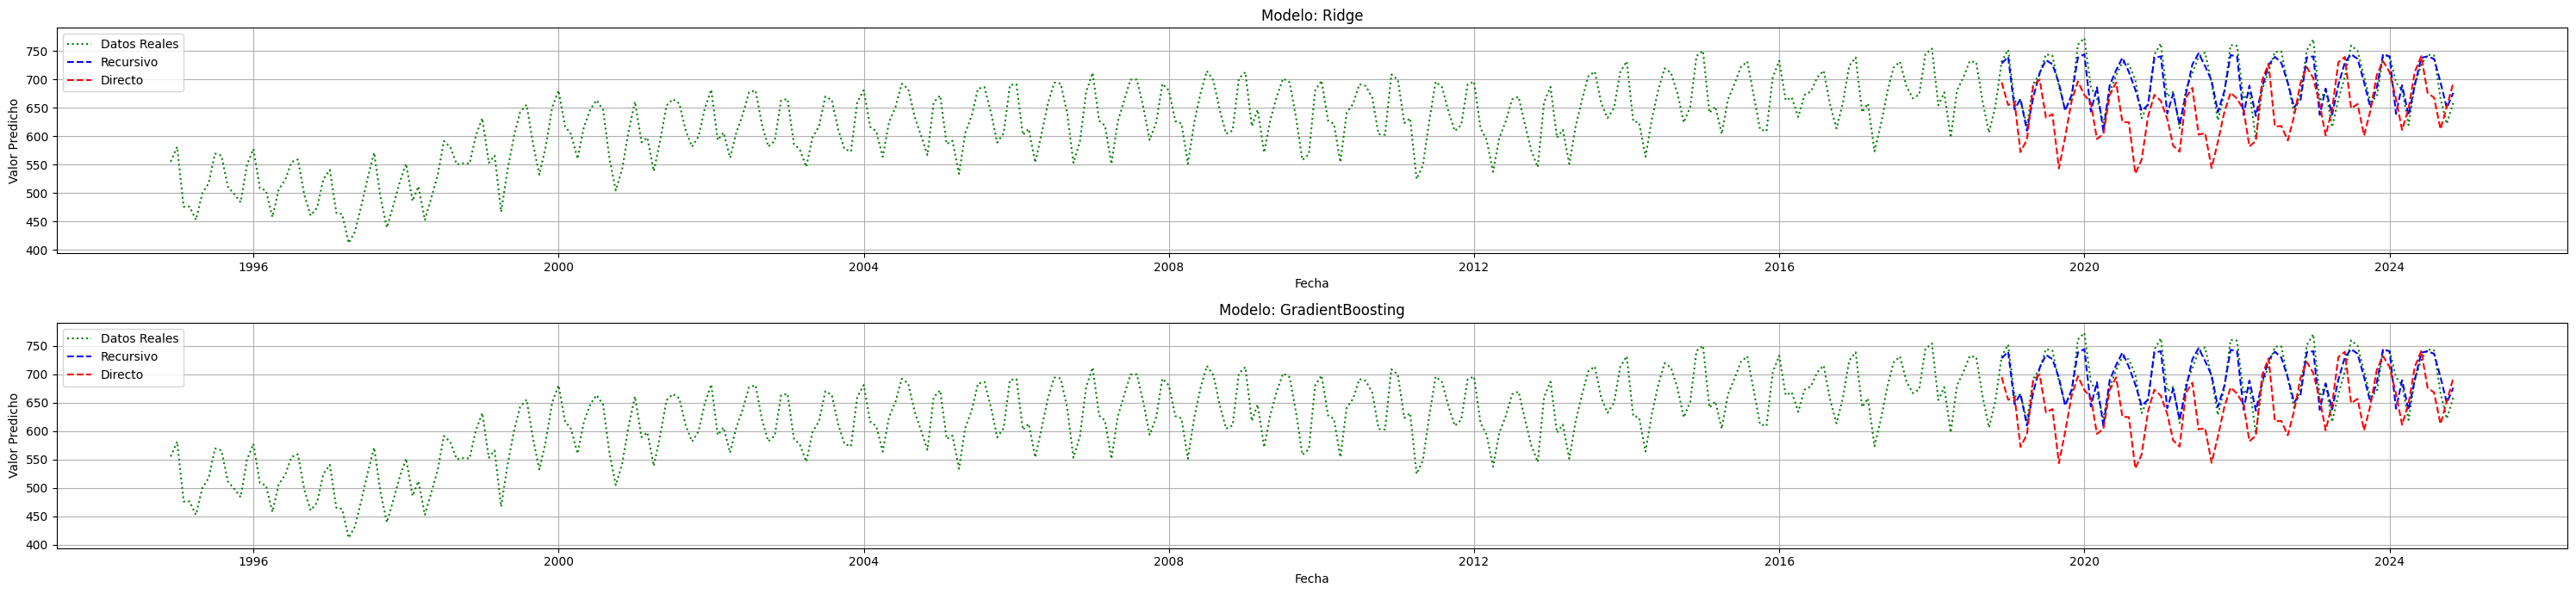

In [18]:
import matplotlib.pyplot as plt

# Crear una figura con subgráficos para cada modelo
fig, axes = plt.subplots(2, 1, figsize=(30, 7))

# Iterar sobre cada modelo y su respectiva gráfica
for (model, ax) in zip(modelos.keys(), axes.flatten()):
    # Obtener predicciones almacenadas en los diccionarios
    pred_recursive = forecaster_recursive.predict(steps=steps)
    pred_direct = forecaster_direct.predict(steps=steps)

    # Graficar datos reales
    ax.plot(Y_data_scaled.index, Y_data_scaled, label="Datos Reales", color="green", linestyle="dotted")

    # Graficar predicción recursiva
    ax.plot(Y_test.index, pred_recursive, label="Recursivo", color="blue", linestyle="dashed")

    # Graficar predicción directa
    ax.plot(Y_test.index, pred_direct, label="Directo", color="red", linestyle="dashed")

    # Configuración de la gráfica
    ax.set_title(f"Modelo: {model}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Valor Predicho")
    ax.legend()
    ax.grid(True)

# Ajustar la distribución de los subgráficos
plt.tight_layout()
plt.show()


In [19]:
pred_recursive,pred_direct

(2018-12-01    727.923363
 2019-01-01    739.557512
 2019-02-01    647.121173
 2019-03-01    665.283545
 2019-04-01    609.595654
                  ...    
 2024-07-01    740.376180
 2024-08-01    736.000643
 2024-09-01    694.786275
 2024-10-01    649.318278
 2024-11-01    676.061434
 Freq: MS, Name: pred, Length: 72, dtype: float64,
 2018-12-01    694.607627
 2019-01-01    654.803567
 2019-02-01    659.501945
 2019-03-01    571.916328
 2019-04-01    593.947493
                  ...    
 2024-07-01    676.124274
 2024-08-01    667.699242
 2024-09-01    612.161806
 2024-10-01    651.726108
 2024-11-01    693.244568
 Freq: MS, Name: pred, Length: 72, dtype: float64)

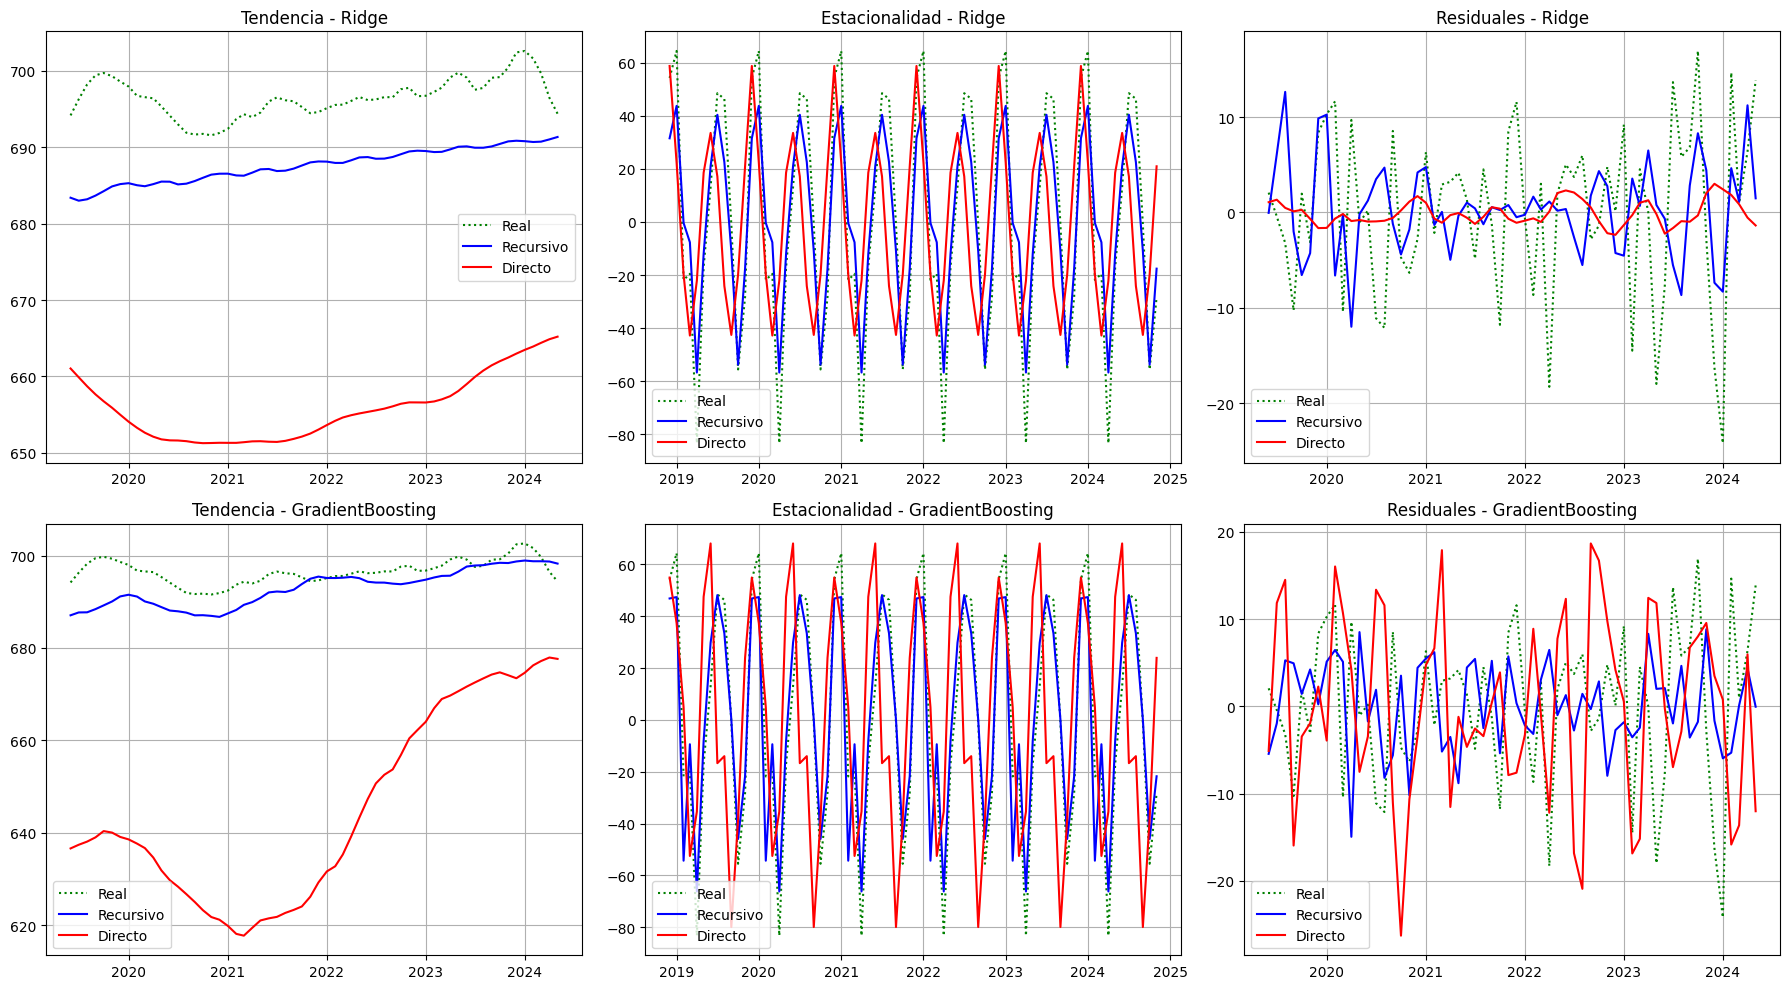

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Crear una figura para visualizar los resultados de cada modelo
fig, axes = plt.subplots(len(modelos), 3, figsize=(18, 5 * len(modelos)))

# Iterar sobre cada modelo y analizar su tendencia y estacionalidad
for i, model_name in enumerate(modelos.keys()):
    # Descomposición de los datos reales (Y_test)
    decomposition_real = seasonal_decompose(Y_test, model="additive", period=12)

    # Descomposición de la predicción recursiva usando el DataFrame
    decomposition_recursive = seasonal_decompose(df_predicciones_recursivas[model_name], model="additive", period=12)

    # Descomposición de la predicción directa usando el DataFrame
    decomposition_direct = seasonal_decompose(df_predicciones_directas[model_name], model="additive", period=12)

    # Graficar tendencia
    axes[i, 0].plot(decomposition_real.trend, label="Real", color="GREEN", linestyle="dotted")
    axes[i, 0].plot(decomposition_recursive.trend, label="Recursivo", color="blue")
    axes[i, 0].plot(decomposition_direct.trend, label="Directo", color="red")
    axes[i, 0].set_title(f"Tendencia - {model_name}")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Graficar estacionalidad
    axes[i, 1].plot(decomposition_real.seasonal, label="Real", color="GREEN", linestyle="dotted")
    axes[i, 1].plot(decomposition_recursive.seasonal, label="Recursivo", color="blue")
    axes[i, 1].plot(decomposition_direct.seasonal, label="Directo", color="red")
    axes[i, 1].set_title(f"Estacionalidad - {model_name}")
    axes[i, 1].legend()
    axes[i, 1].grid(True)

    # Graficar residuales
    axes[i, 2].plot(decomposition_real.resid, label="Real", color="GREEN", linestyle="dotted")
    axes[i, 2].plot(decomposition_recursive.resid, label="Recursivo", color="blue")
    axes[i, 2].plot(decomposition_direct.resid, label="Directo", color="red")
    axes[i, 2].set_title(f"Residuales - {model_name}")
    axes[i, 2].legend()
    axes[i, 2].grid(True)

# Ajustar diseño
plt.tight_layout()
plt.show()




In [21]:
#Ahora realizamosel mismo ajuste para hacer el forecasting con la regresion lineal

variables_exogenas = ["Share_of_Electricity_Percent", "Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]
X_escalado,Y_data, scaler=escalar_xy(monthly_data_per_unit,variables_exogenas)
X_copy_forecasting = X_escalado.copy()
X_copy_forecasting['Date'] = pd.to_datetime(X_copy_forecasting['Date'], format='%Y%m')
X_copy_forecasting.set_index('Date', inplace=True)
Y_copy_forecasting = Y_data.copy()
Y_copy_forecasting.index = X_copy_forecasting.index
X_copy_forecasting.head(),Y_copy_forecasting.head()

(            Share_of_Electricity_Percent  Capacity_Factor_Percent  \
 Date                                                                
 1994-12-01                      0.932479                -1.184454   
 1995-01-01                      1.060166                -0.841658   
 1995-02-01                     -0.216701                -1.553620   
 1995-03-01                     -0.663605                -2.212844   
 1995-04-01                     -0.472075                -2.309530   
 
             Net_Summer_Capacity_MW  
 Date                                
 1994-12-01               -1.898114  
 1995-01-01               -1.898114  
 1995-02-01               -1.898114  
 1995-03-01               -1.898114  
 1995-04-01               -1.898114  ,
 Date
 1994-12-01    555.018349
 1995-01-01    581.119266
 1995-02-01    475.761468
 1995-03-01    475.963303
 1995-04-01    452.486239
 Name: Net_Generation_MWh, dtype: float64)

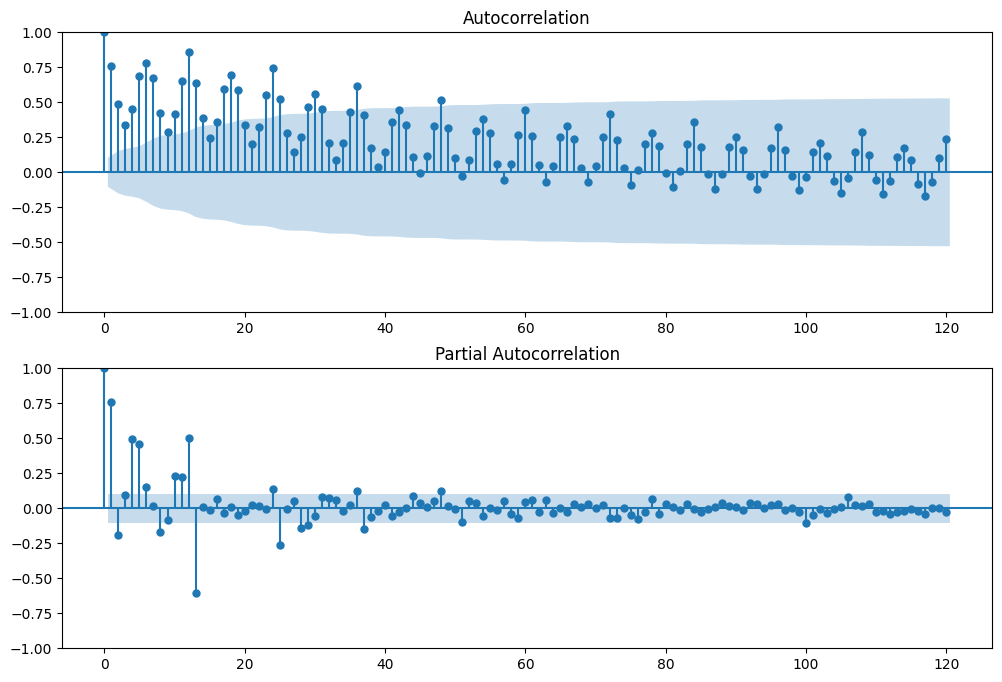

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Graficar la autocorrelación hasta 120 meses
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(Y_data_scaled, lags=120, ax=ax[0])
plot_pacf(Y_data_scaled, lags=120, ax=ax[1])
plt.show()

In [23]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import Ridge

# Definir diferentes combinaciones de lags
lag_options = [
    list(np.arange(1, 34, 1)),
    list(np.arange(1, 35, 1)),
    list(np.arange(1, 36, 1)),
]

steps = 180  # 15 años (180 meses)

# Diccionarios para almacenar los resultados
resultados_direct = {}
resultados_recursive = {}

# Iterar sobre cada conjunto de lags para ForecasterDirect
for lags in lag_options:
    # Crear el modelo con los lags actuales para método Directo
    forecaster_direct = ForecasterDirect(regressor=Ridge(), steps=steps, lags=lags)

    # Ajustar el modelo
    forecaster_direct.fit(Y_data_scaled)

    # Hacer predicciones
    predicciones_direct = forecaster_direct.predict(steps=steps)

    # Calcular el error cuadrático medio
    error_direct = mean_squared_error(Y_data_scaled[-steps:], predicciones_direct)

    # Guardar resultados
    resultados_direct[str(lags)] = error_direct
    print(f"[Directo] Lags: {lags} -> RMSE: {np.sqrt(error_direct):.4f}")


# Encontrar la mejor combinación de lags
best_lags_direct = min(resultados_direct, key=resultados_direct.get)


best_lags_direct,

[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] -> RMSE: 24.2874
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] -> RMSE: 23.9952
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] -> RMSE: 24.2693


('[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]',)

In [24]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import Ridge

# Definir diferentes combinaciones de lags
lag_options = [
    list(np.arange(1, 31, 1)),
    list(np.arange(1, 32, 1)),
    list(np.arange(1, 33, 1))# Convertir a lista para evitar errores
]

steps = 180  # 15 años (180 meses)

# Diccionarios para almacenar los resultados
resultados_direct = {}
resultados_recursive = {}

# Iterar sobre cada conjunto de lags para ForecasterDirect
for lags in lag_options:
    # Crear el modelo con los lags actuales para método Directo
    forecaster_direct = ForecasterDirect(regressor=GradientBoostingRegressor(), steps=steps, lags=lags)

    # Ajustar el modelo
    forecaster_direct.fit(Y_data_scaled)

    # Hacer predicciones
    predicciones_direct = forecaster_direct.predict(steps=steps)

    # Calcular el error cuadrático medio
    error_direct = mean_squared_error(Y_data_scaled[-steps:], predicciones_direct)

    # Guardar resultados
    resultados_direct[str(lags)] = error_direct
    print(f"[Directo] Lags: {lags} -> RMSE: {np.sqrt(error_direct):.4f}")


# Encontrar la mejor combinación de lags
best_lags_direct = min(resultados_direct, key=resultados_direct.get)


best_lags_direct

[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] -> RMSE: 40.4867
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] -> RMSE: 39.9384
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32] -> RMSE: 40.5126


'[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]'

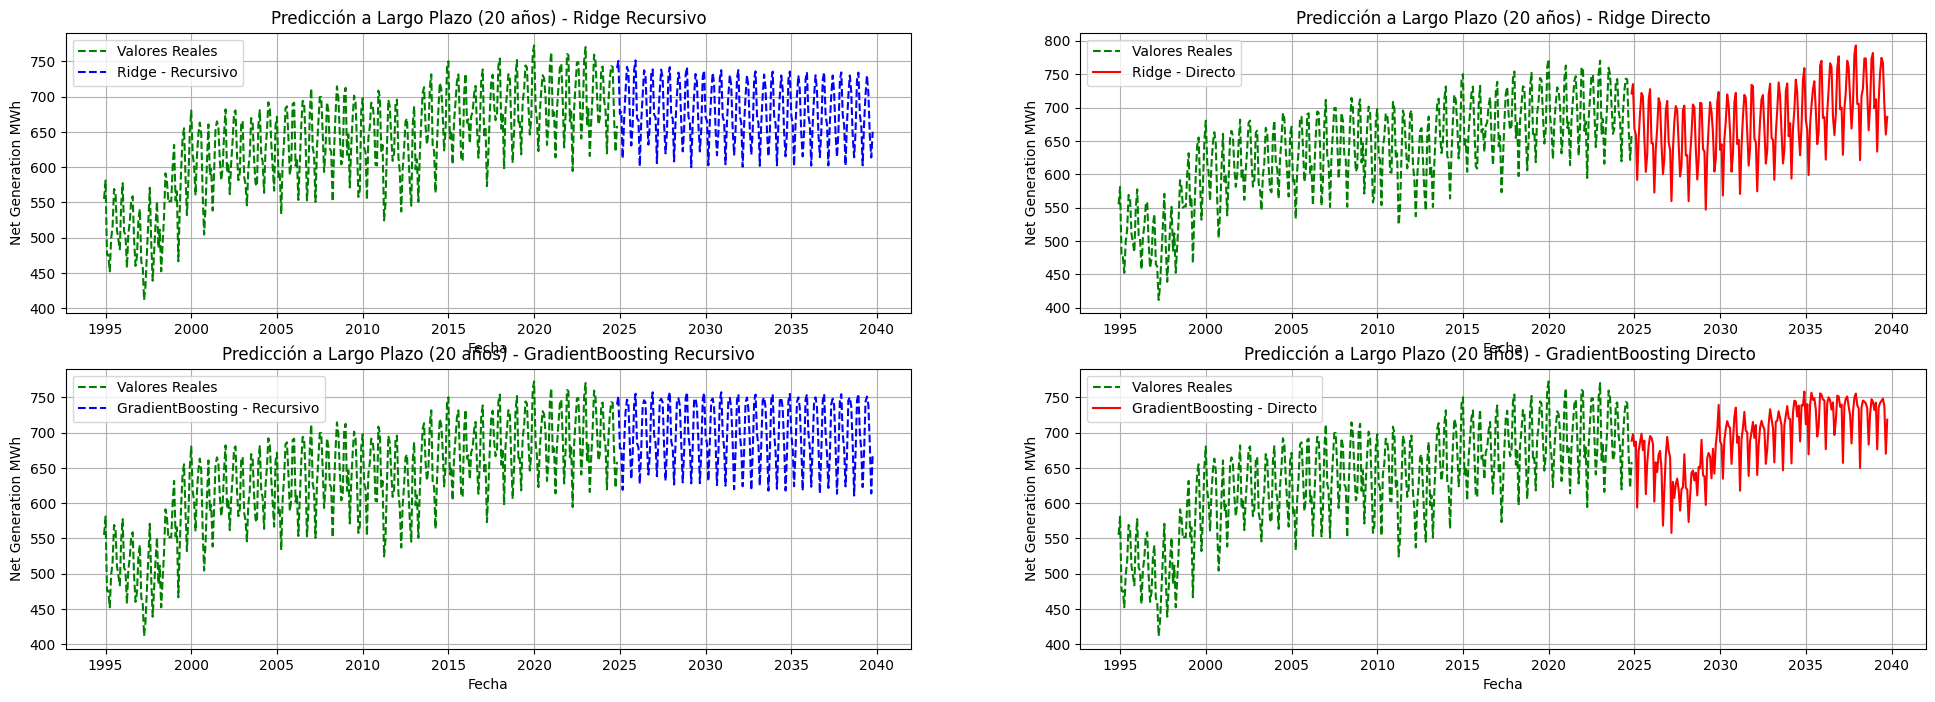

📊 Evaluación a 15 años para Ridge:
Método Recursivo - Media de predicción: 678.99
Método Directo   - Media de predicción: 679.37

📊 Evaluación a 15 años para GradientBoosting:
Método Recursivo - Media de predicción: 698.70
Método Directo   - Media de predicción: 692.95



In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from skforecast.direct import ForecasterDirect
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# 1️⃣ **Preprocesamiento y selección de datos**
Y_copy_forecasting = Y_copy_forecasting.asfreq('MS')  # Asegurar frecuencia mensual

# Convertir en Serie con el índice temporal
Y_data_scaled = pd.Series(Y_copy_forecasting, index=Y_copy_forecasting.index)

# 3️⃣ **Definir parámetros de predicción**
años = 15
#lags = [3,12, 24, 36, 60, 120]  # Usaremos rezagos de 6, 12 y 24 meses
lags = np.arange(1,20,1)
steps = años * 12  # Queremos predecir los próximos 20 años (240 meses)

# 4️⃣ **Definir modelos**
modelos = {
    "Ridge": Ridge(),
    "GradientBoosting": GradientBoostingRegressor()
}

# Diccionario para almacenar predicciones
predicciones = {}

# Iterar sobre los modelos
for model_name, model in modelos.items():
    # 🔸 **Método Recursivo (Autoregresivo)**
    forecaster_recursive = ForecasterRecursive(
        regressor=model,
        lags=np.arange(1,40,1)
    )
    forecaster_recursive.fit(Y_data_scaled)
    pred_recursive = forecaster_recursive.predict(steps=steps)

    # 🔸 **Método Directo**
    forecaster_direct = ForecasterDirect(
        regressor=model,
        steps=steps,
        lags=np.arange(1,35,1)
    )
    forecaster_direct.fit(Y_data_scaled)
    pred_direct = forecaster_direct.predict()
    # Guardar predicciones
    predicciones[model_name] = {
        "recursivo": pred_recursive,
        "directo": pred_direct
    }


# 6️⃣ **Visualización de Resultados**
# Crear una figura con dos subgráficos para cada modelo
fig, axes = plt.subplots(2, 2, figsize=(24, 8))

# Obtener las fechas de predicción
pred_dates = pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps, freq="MS")

# Graficar predicciones para Ridge
axes[0,0].plot(Y_copy_forecasting.index, Y_data_scaled, label="Valores Reales", linestyle="dashed", color="green")
axes[0,0].plot(pred_dates, predicciones["Ridge"]["recursivo"], label="Ridge - Recursivo", linestyle="dashed", color="blue")
axes[0,1].plot(Y_copy_forecasting.index, Y_data_scaled, label="Valores Reales", linestyle="dashed", color="green")
axes[0,1].plot(pred_dates, predicciones["Ridge"]["directo"], label="Ridge - Directo", linestyle="solid", color="red")
axes[0,0].set_xlabel("Fecha")
axes[0,0].set_ylabel("Net Generation MWh")
axes[0,0].set_title("Predicción a Largo Plazo (20 años) - Ridge Recursivo")
axes[0,0].legend()
axes[0,0].grid(True)
axes[0,1].set_xlabel("Fecha")
axes[0,1].set_ylabel("Net Generation MWh")
axes[0,1].set_title("Predicción a Largo Plazo (20 años) - Ridge Directo")
axes[0,1].legend()
axes[0,1].grid(True)


# Graficar predicciones para Gradient Boosting
axes[1,0].plot(Y_copy_forecasting.index, Y_data_scaled, label="Valores Reales", linestyle="dashed", color="green")
axes[1,0].plot(pred_dates, predicciones["GradientBoosting"]["recursivo"], label="GradientBoosting - Recursivo", linestyle="dashed", color="blue")
axes[1,1].plot(Y_copy_forecasting.index, Y_data_scaled, label="Valores Reales", linestyle="dashed", color="green")
axes[1,1].plot(pred_dates, predicciones["GradientBoosting"]["directo"], label="GradientBoosting - Directo", linestyle="solid", color="red")
axes[1,0].set_xlabel("Fecha")
axes[1,0].set_ylabel("Net Generation MWh")
axes[1,0].set_title("Predicción a Largo Plazo (20 años) - GradientBoosting Recursivo")
axes[1,0].legend()
axes[1,0].grid(True)
axes[1,1].set_xlabel("Fecha")
axes[1,1].set_ylabel("Net Generation MWh")
axes[1,1].set_title("Predicción a Largo Plazo (20 años) - GradientBoosting Directo ")
axes[1,1].legend()
axes[1,1].grid(True)

# Ajustar diseño y mostrar
plt.show()

# 7️⃣ **Evaluación del Comportamiento de la Predicción**
for model_name, preds in predicciones.items():
    print(f"📊 Evaluación a {años} años para {model_name}:")
    print(f"Método Recursivo - Media de predicción: {np.mean(preds['recursivo']):.2f}")
    print(f"Método Directo   - Media de predicción: {np.mean(preds['directo']):.2f}\n")



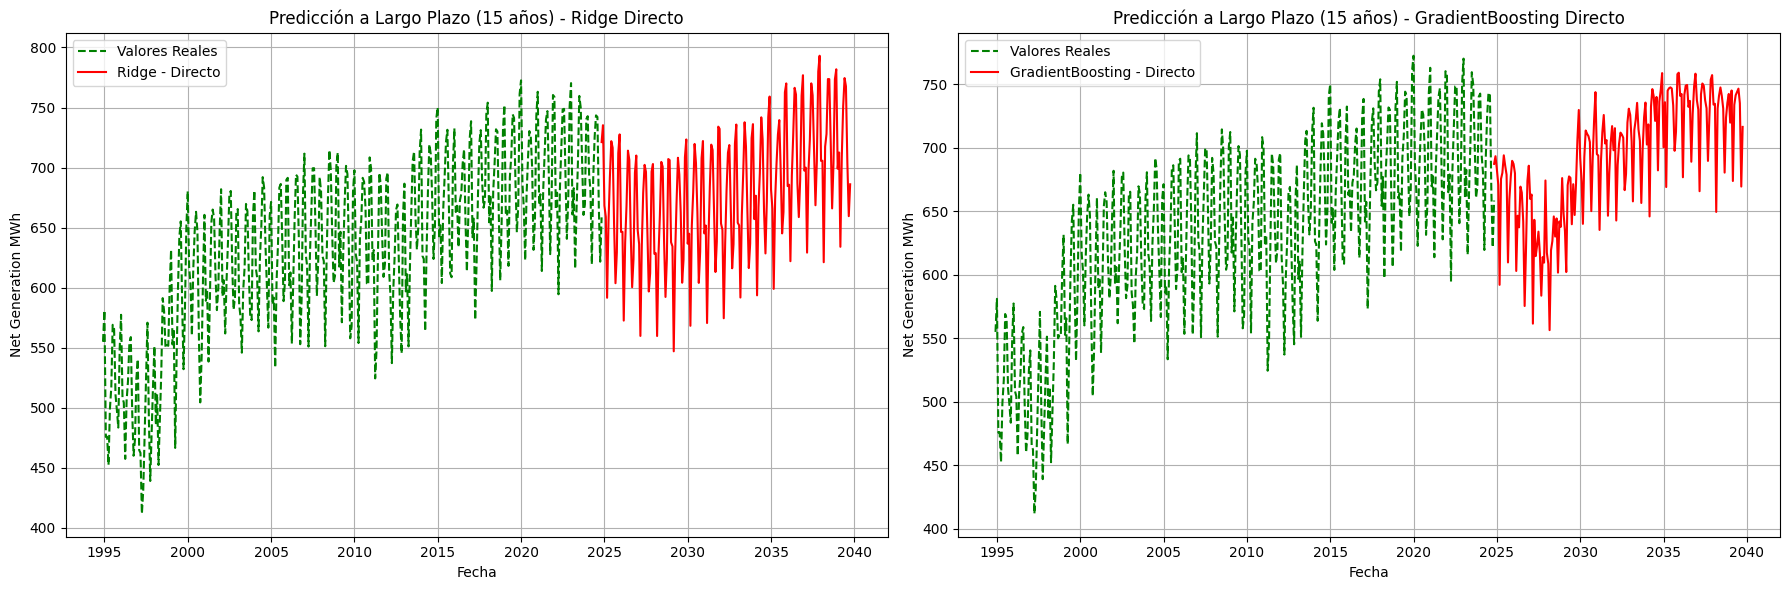

📊 Evaluación a 15 años para Ridge:
Método Directo - Media de predicción: 679.37

📊 Evaluación a 15 años para GradientBoosting:
Método Directo - Media de predicción: 692.09



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skforecast.direct import ForecasterDirect
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# 1️⃣ **Preprocesamiento y selección de datos**
Y_copy_forecasting = Y_copy_forecasting.asfreq('MS')  # Asegurar frecuencia mensual
Y_data_scaled = pd.Series(Y_copy_forecasting, index=Y_copy_forecasting.index)

# 2️⃣ **Definir parámetros de predicción**
años = 15
steps = años * 12  # 15 años en meses

# 3️⃣ **Definir modelos y lags específicos**
modelos = {
    "Ridge": {"model": Ridge(), "lags": np.arange(1, 35, 1)},
    "GradientBoosting": {"model": GradientBoostingRegressor(), "lags": np.arange(1, 32, 1)}
}

# Diccionario para almacenar predicciones
predicciones = {}

# Iterar sobre los modelos (solo método Directo)
for model_name, config in modelos.items():
    forecaster_direct = ForecasterDirect(
        regressor=config["model"],
        steps=steps,
        lags=config["lags"]
    )
    forecaster_direct.fit(Y_data_scaled)
    pred_direct = forecaster_direct.predict()

    # Guardar predicciones
    predicciones[model_name] = pred_direct

# 4️⃣ **Visualización de Resultados**
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Obtener las fechas de predicción
pred_dates = pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps, freq="MS")

# Graficar predicciones para cada modelo
for ax, (model_name, preds) in zip(axes, predicciones.items()):
    ax.plot(Y_copy_forecasting.index, Y_data_scaled, label="Valores Reales", linestyle="dashed", color="green")
    ax.plot(pred_dates, preds, label=f"{model_name} - Directo", linestyle="solid", color="red")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Net Generation MWh")
    ax.set_title(f"Predicción a Largo Plazo ({años} años) - {model_name} Directo")
    ax.legend()
    ax.grid(True)

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

# 5️⃣ **Evaluación del Comportamiento de la Predicción**
for model_name, preds in predicciones.items():
    print(f"📊 Evaluación a {años} años para {model_name}:")
    print(f"Método Directo - Media de predicción: {np.mean(preds):.2f}\n")


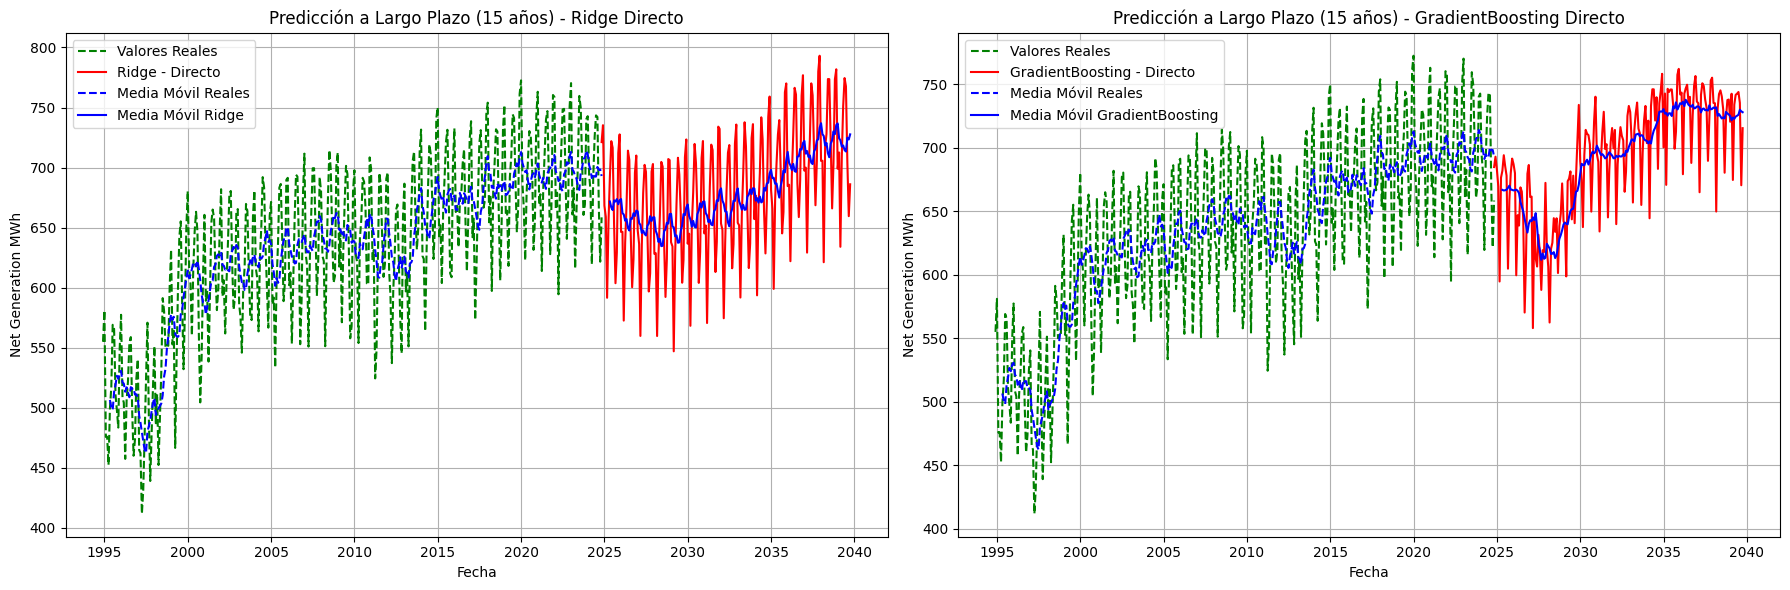

📊 Evaluación a 15 años para Ridge:
Método Directo - Media de predicción: 679.37

📊 Evaluación a 15 años para GradientBoosting:
Método Directo - Media de predicción: 692.19



In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.direct import ForecasterDirect
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# 1️⃣ **Preprocesamiento y selección de datos**
Y_copy_forecasting = Y_copy_forecasting.asfreq('MS')  # Asegurar frecuencia mensual
Y_data_scaled = pd.Series(Y_copy_forecasting, index=Y_copy_forecasting.index)

# 2️⃣ **Definir parámetros de predicción**
años = 15
steps = años * 12  # 15 años en meses
window_size = 6  # Ventana de 12 meses para la media móvil

# 3️⃣ **Definir modelos y lags específicos**
modelos = {
    "Ridge": {"model": Ridge(), "lags": np.arange(1, 35, 1)},
    "GradientBoosting": {"model": GradientBoostingRegressor(), "lags": np.arange(1, 32, 1)}
}

# Diccionario para almacenar predicciones
predicciones = {}

# Iterar sobre los modelos (solo método Directo)
for model_name, config in modelos.items():
    forecaster_direct = ForecasterDirect(
        regressor=config["model"],
        steps=steps,
        lags=config["lags"]
    )
    forecaster_direct.fit(Y_data_scaled)
    pred_direct = forecaster_direct.predict()

    # Guardar predicciones
    predicciones[model_name] = pred_direct

# 4️⃣ **Visualización de Resultados**
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Obtener las fechas de predicción
pred_dates = pd.date_range(start=Y_copy_forecasting.index[-1], periods=steps, freq="MS")

# Calcular la media móvil de los datos reales
media_movil_reales = Y_data_scaled.rolling(window=window_size).mean()

# Graficar predicciones para cada modelo con medias móviles
for ax, (model_name, preds) in zip(axes, predicciones.items()):
    # Calcular la media móvil de la predicción
    media_movil_pred = pd.Series(preds, index=pred_dates).rolling(window=window_size).mean()

    # Graficar datos reales
    ax.plot(Y_copy_forecasting.index, Y_data_scaled, label="Valores Reales", linestyle="dashed", color="green")

    # Graficar predicción
    ax.plot(pred_dates, preds, label=f"{model_name} - Directo", linestyle="solid", color="red")

    # Graficar media móvil de los datos reales
    ax.plot(Y_copy_forecasting.index, media_movil_reales, label="Media Móvil Reales", linestyle="dashed", color="blue")

    # Graficar media móvil de la predicción
    ax.plot(pred_dates, media_movil_pred, label=f"Media Móvil {model_name}", linestyle="solid", color="blue")

    ax.set_xlabel("Fecha")
    ax.set_ylabel("Net Generation MWh")
    ax.set_title(f"Predicción a Largo Plazo ({años} años) - {model_name} Directo")
    ax.legend()
    ax.grid(True)

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

# 5️⃣ **Evaluación del Comportamiento de la Predicción**
for model_name, preds in predicciones.items():
    print(f"📊 Evaluación a {años} años para {model_name}:")
    print(f"Método Directo - Media de predicción: {np.mean(preds):.2f}\n")




In [28]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import Ridge

# Definir diferentes combinaciones de lags
lag_options = [
    list(np.arange(1, 30, 1)),
    list(np.arange(1, 31, 1)),
    list(np.arange(1, 32, 1)),
    list(np.arange(1, 33, 1)),
    list(np.arange(1, 34, 1)),
    list(np.arange(1, 35, 1)),
    list(np.arange(1, 36, 1)),
    list(np.arange(1, 37, 1)),
    list(np.arange(1, 38, 1)),
    list(np.arange(1, 39, 1)),
    list(np.arange(1, 40, 1))  # Convertir a lista para evitar errores
]

steps = 180  # 15 años (180 meses)

# Diccionarios para almacenar los resultados
resultados_direct = {}
resultados_recursive = {}

# Iterar sobre cada conjunto de lags para ForecasterDirect
for lags in lag_options:
    # Crear el modelo con los lags actuales para método Directo
    forecaster_direct = ForecasterDirect(regressor=Ridge(), steps=steps, lags=lags)

    # Ajustar el modelo
    forecaster_direct.fit(Y_data_scaled)

    # Hacer predicciones
    predicciones_direct = forecaster_direct.predict(steps=steps)

    # Calcular el error cuadrático medio
    error_direct = mean_squared_error(Y_data_scaled[-steps:], predicciones_direct)

    # Guardar resultados
    resultados_direct[str(lags)] = error_direct
    print(f"[Directo] Lags: {lags} -> RMSE: {np.sqrt(error_direct):.4f}")

# Iterar sobre cada conjunto de lags para ForecasterRecursive
for lags in lag_options:
    # Crear el modelo con los lags actuales para método Recursivo
    forecaster_recursive = ForecasterRecursive(regressor=Ridge(), lags=lags)

    # Ajustar el modelo
    forecaster_recursive.fit(Y_data_scaled)

    # Hacer predicciones
    predicciones_recursive = forecaster_recursive.predict(steps=steps)

    # Calcular el error cuadrático medio
    error_recursive = mean_squared_error(Y_data_scaled[-steps:], predicciones_recursive)

    # Guardar resultados
    resultados_recursive[str(lags)] = error_recursive
    print(f"[Recursivo] Lags: {lags} -> RMSE: {np.sqrt(error_recursive):.4f}")

# Encontrar la mejor combinación de lags
best_lags_direct = min(resultados_direct, key=resultados_direct.get)
best_lags_recursive = min(resultados_recursive, key=resultados_recursive.get)

best_lags_direct, best_lags_recursive



[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] -> RMSE: 24.1743
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] -> RMSE: 24.4063
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] -> RMSE: 24.5311
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32] -> RMSE: 24.2144
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] -> RMSE: 24.2874
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] -> RMSE: 23.9952
[Directo] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22

('[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]',
 '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]')

In [58]:
#Ahora realizamosel mismo ajuste para hacer el forecasting con la regresion lineal

variables_exogenas = ["Share_of_Electricity_Percent", "Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]
X_escalado,Y_data, scaler=escalar_xy(monthly_data_per_unit,variables_exogenas)
X_copy_forecasting = X_escalado.copy()
X_copy_forecasting['Date'] = pd.to_datetime(X_copy_forecasting['Date'], format='%Y%m')
X_copy_forecasting.set_index('Date', inplace=True)
Y_copy_forecasting = Y_data.copy()
Y_copy_forecasting.index = X_copy_forecasting.index
X_copy_forecasting.head(),Y_copy_forecasting.head()

(            Share_of_Electricity_Percent  Capacity_Factor_Percent  \
 Date                                                                
 1994-12-01                      0.932479                -1.184454   
 1995-01-01                      1.060166                -0.841658   
 1995-02-01                     -0.216701                -1.553620   
 1995-03-01                     -0.663605                -2.212844   
 1995-04-01                     -0.472075                -2.309530   
 
             Net_Summer_Capacity_MW  
 Date                                
 1994-12-01               -1.898114  
 1995-01-01               -1.898114  
 1995-02-01               -1.898114  
 1995-03-01               -1.898114  
 1995-04-01               -1.898114  ,
 Date
 1994-12-01    555.018349
 1995-01-01    581.119266
 1995-02-01    475.761468
 1995-03-01    475.963303
 1995-04-01    452.486239
 Name: Net_Generation_MWh, dtype: float64)

📊 Prediciendo Share_of_Electricity_Percent con Ridge y Gradient Boosting...
📊 Prediciendo Capacity_Factor_Percent con Ridge y Gradient Boosting...
📊 Prediciendo Net_Summer_Capacity_MW con Ridge y Gradient Boosting...


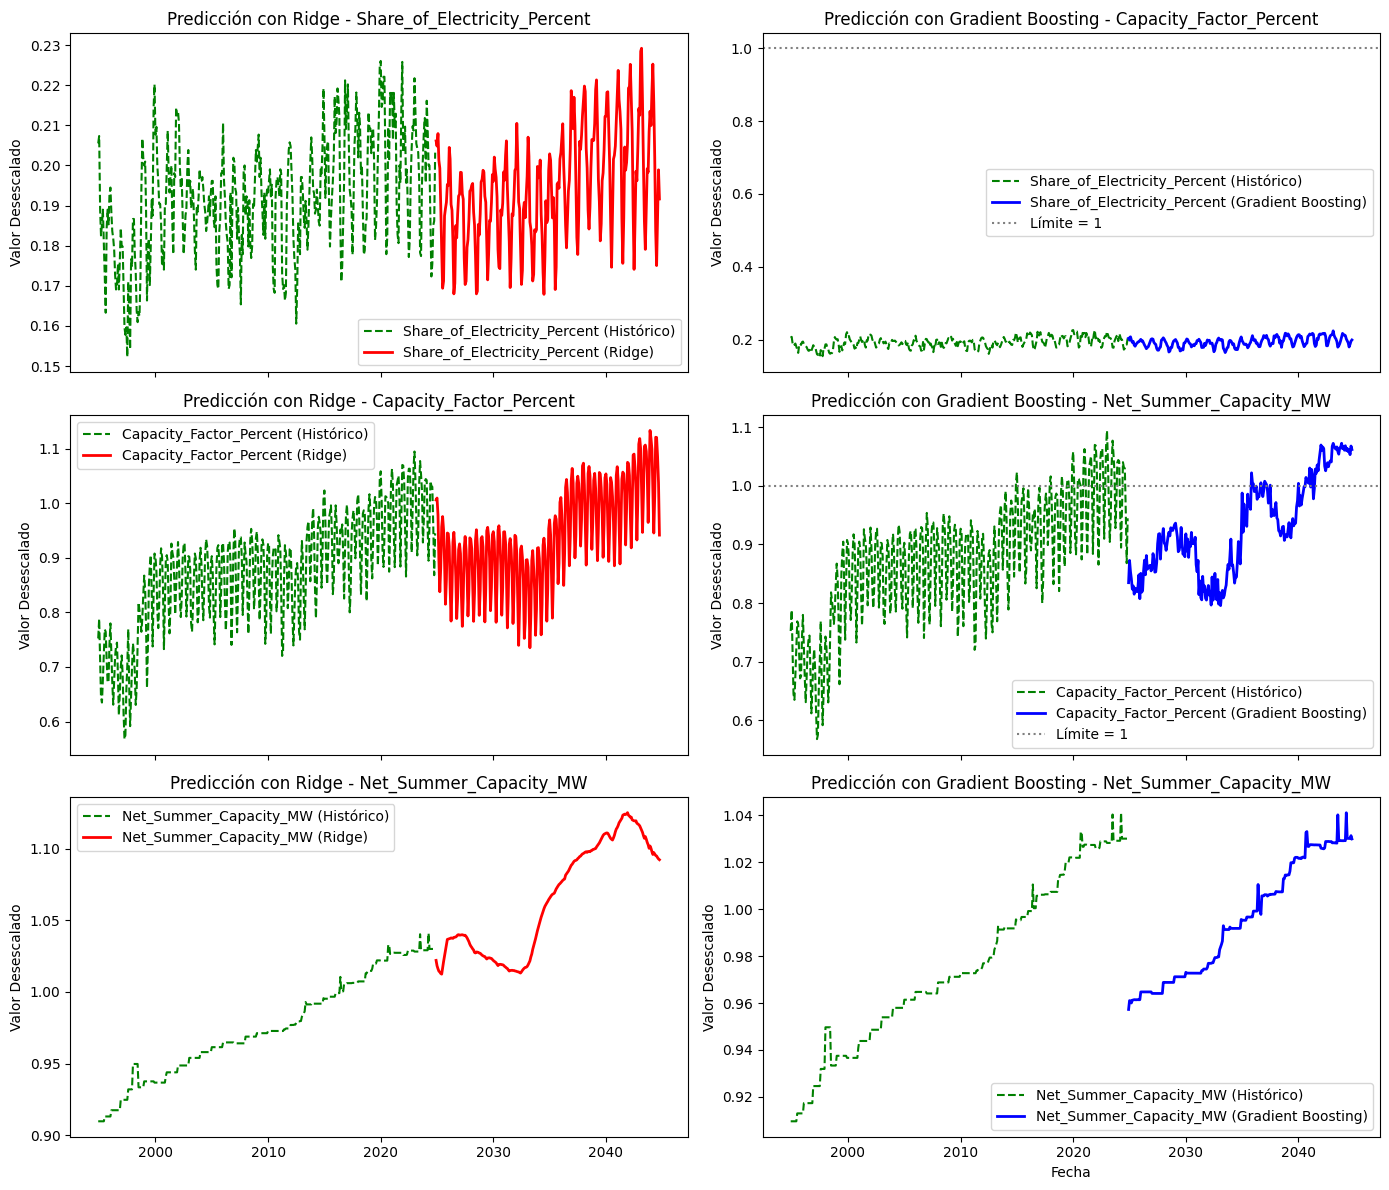

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.direct import ForecasterDirect
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# 1️⃣ **Asegurar frecuencia mensual**
X_copy_forecasting = X_copy_forecasting.asfreq('MS')

# 2️⃣ **Inicializar diccionarios para guardar predicciones futuras**
X_future_ridge = {}
X_future_gb = {}

# 3️⃣ **Definir rezagos y horizonte de predicción**
lags = np.arange(1, 32, 1)
steps = 20 * 12  # Predicción para 20 años (240 meses)

# 4️⃣ **Iterar sobre cada variable exógena y hacer predicciones con Ridge y Gradient Boosting**
for var in X_copy_forecasting.columns:
    print(f"📊 Prediciendo {var} con Ridge y Gradient Boosting...")

    # 🔹 **Modelo Ridge**
    forecaster_ridge = ForecasterDirect(
        regressor=Ridge(),
        steps=steps,
        lags=lags
    )
    forecaster_ridge.fit(y=X_copy_forecasting[var])
    X_future_ridge[var] = forecaster_ridge.predict(steps=steps)

    # 🔹 **Modelo Gradient Boosting**
    forecaster_gb = ForecasterDirect(
        regressor=GradientBoostingRegressor(),
        steps=steps,
        lags=lags
    )
    forecaster_gb.fit(y=X_copy_forecasting[var])
    X_future_gb[var] = forecaster_gb.predict(steps=steps)

# 5️⃣ **Convertir predicciones en DataFrames con fechas futuras**
X_future_ridge = pd.DataFrame(X_future_ridge, index=pd.date_range(start=X_copy_forecasting.index[-1], periods=steps, freq="MS"))
X_future_gb = pd.DataFrame(X_future_gb, index=pd.date_range(start=X_copy_forecasting.index[-1], periods=steps, freq="MS"))

# 6️⃣ **Desescalar las predicciones usando los scalers guardados**
for col in variables_exogenas:
    X_future_ridge[col] = scalers[col].inverse_transform(X_future_ridge[[col]])
    X_future_gb[col] = scalers[col].inverse_transform(X_future_gb[[col]])

# 7️⃣ **Desescalar X_copy_forecasting**
for col in variables_exogenas:
    X_copy_forecasting[col] = scalers[col].inverse_transform(X_copy_forecasting[[col]])

# 8️⃣ **Visualización de Resultados**
num_vars = len(X_copy_forecasting.columns)
fig, axes = plt.subplots(num_vars, 2, figsize=(14, 4 * num_vars), sharex=True)

# Obtener las fechas de predicción
pred_dates = X_future_ridge.index


# 🔹 **Graficar predicciones para cada variable y cada modelo**
for i, var in enumerate(X_copy_forecasting.columns):
    # Ridge (primera columna)
    ax_ridge = axes[i, 0] if num_vars > 1 else axes[0]
    ax_ridge.plot(X_copy_forecasting.index, X_copy_forecasting[var], label=f"{var} (Histórico)", linestyle="dashed", color="green")
    ax_ridge.plot(pred_dates, X_future_ridge[var], label=f"{var} (Ridge)", linewidth=2, color="red")

    # 🔹 Si la variable es 'Capacity_Factor_Percent', agregar una línea horizontal en y=1
    if var == "Capacity_Factor_Percent":
        ax_gb.axhline(y=1, color="gray", linestyle="dotted", linewidth=1.5, label="Límite = 1")

    ax_gb.set_ylabel("Valor Desescalado")
    ax_gb.set_title(f"Predicción con Gradient Boosting - {var}")
    ax_gb.legend()

    ax_ridge.set_ylabel("Valor Desescalado")
    ax_ridge.set_title(f"Predicción con Ridge - {var}")
    ax_ridge.legend()

    # Gradient Boosting (segunda columna)
    ax_gb = axes[i, 1] if num_vars > 1 else axes[1]
    ax_gb.plot(X_copy_forecasting.index, X_copy_forecasting[var], label=f"{var} (Histórico)", linestyle="dashed", color="green")
    ax_gb.plot(pred_dates, X_future_gb[var], label=f"{var} (Gradient Boosting)", linewidth=2, color="blue")

    # 🔹 Si la variable es 'Capacity_Factor_Percent', agregar una línea horizontal en y=1
    if var == "Capacity_Factor_Percent":
        ax_gb.axhline(y=1, color="gray", linestyle="dotted", linewidth=1.5, label="Límite = 1")

    ax_gb.set_ylabel("Valor Desescalado")
    ax_gb.set_title(f"Predicción con Gradient Boosting - {var}")
    ax_gb.legend()

# Etiqueta común para el eje X
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()



📊 Prediciendo Share_of_Electricity_Percent con SARIMAX...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


📊 Prediciendo Capacity_Factor_Percent con SARIMAX...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


📊 Prediciendo Net_Summer_Capacity_MW con SARIMAX...

📌 Predicciones a futuro de las variables exógenas:
            Share_of_Electricity_Percent  Capacity_Factor_Percent  \
2024-11-01                           NaN                      NaN   
2024-12-01                      0.195077                 0.982792   
2025-01-01                      0.195008                 0.984882   
2025-02-01                      0.195017                 0.981256   
2025-03-01                      0.194989                 0.973229   

            Net_Summer_Capacity_MW  
2024-11-01                     NaN  
2024-12-01                1.011824  
2025-01-01                1.011810  
2025-02-01                1.011811  
2025-03-01                1.011810  


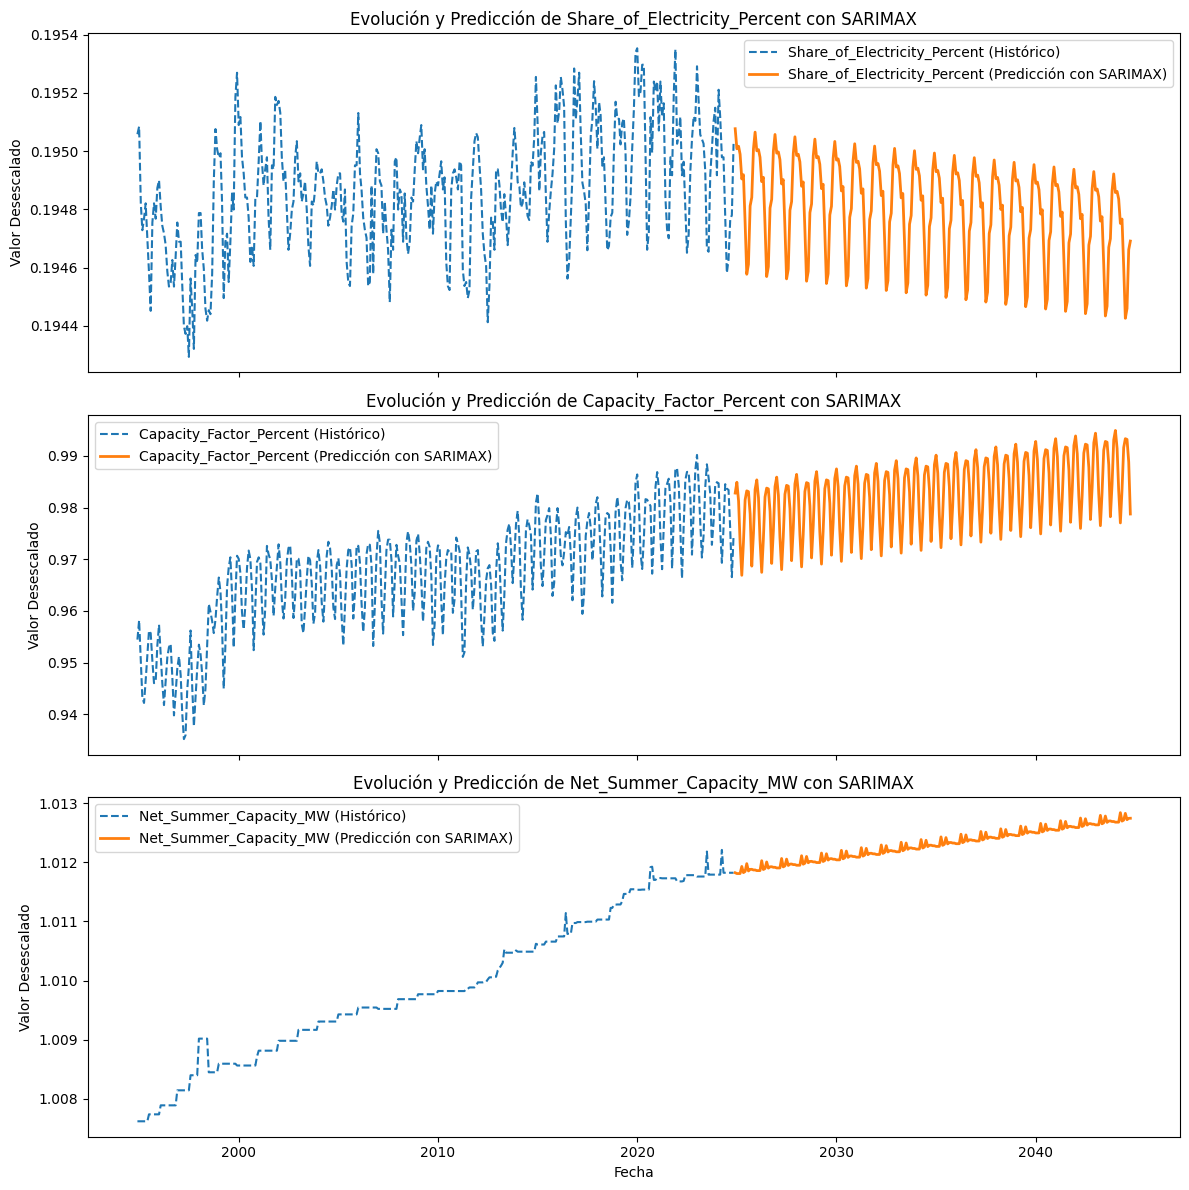

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1️⃣ **Asegurar frecuencia mensual**
X_copy_forecasting = X_copy_forecasting.asfreq('MS')

# 2️⃣ **Inicializar diccionario para guardar predicciones futuras**
X_future = {}

# 3️⃣ **Definir parámetros del modelo SARIMAX**
steps = 20 * 12  # Predicción para 20 años (240 meses)
sarima_order = (2, 1, 2)  # Parámetros (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Parámetros estacionales (P, D, Q, S)

# 4️⃣ **Iterar sobre cada variable exógena y hacer predicciones con SARIMAX**
for var in X_copy_forecasting.columns:
    print(f"📊 Prediciendo {var} con SARIMAX...")

    # Definir modelo SARIMAX para la variable actual
    model = SARIMAX(
        X_copy_forecasting[var],
        order=sarima_order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Ajustar el modelo
    fitted_model = model.fit(disp=False)

    # Hacer predicciones a futuro
    pred = fitted_model.forecast(steps=steps)

    # Guardar predicción en el diccionario
    X_future[var] = pred

# 5️⃣ **Convertir X_future en un DataFrame con índice de fechas futuras**
X_future = pd.DataFrame(X_future, index=pd.date_range(start=X_copy_forecasting.index[-1], periods=steps, freq="MS"))

# 6️⃣ **Desescalar las predicciones usando los scalers guardados**
for col in variables_exogenas:
    X_future[col] = scalers[col].inverse_transform(X_future[[col]])

# 7️⃣ **Desescalar X_copy_forecasting**
for col in variables_exogenas:
    X_copy_forecasting[col] = scalers[col].inverse_transform(X_copy_forecasting[[col]])

# 8️⃣ **Mostrar primeras predicciones**
print("\n📌 Predicciones a futuro de las variables exógenas:")
print(X_future.head())

# 9️⃣ **Visualización de Resultados**
num_vars = len(X_copy_forecasting.columns)
fig, axes = plt.subplots(num_vars, 1, figsize=(12, 4 * num_vars), sharex=True)

# Graficar cada variable exógena en un subplot distinto
for i, var in enumerate(X_copy_forecasting.columns):
    ax = axes[i] if num_vars > 1 else axes  # Ajustar si solo hay una variable
    ax.plot(X_copy_forecasting.index, X_copy_forecasting[var], label=f"{var} (Histórico)", linestyle="dashed")
    ax.plot(X_future.index, X_future[var], label=f"{var} (Predicción con SARIMAX)", linewidth=2)
    ax.set_ylabel("Valor Desescalado")
    ax.set_title(f"Evolución y Predicción de {var} con SARIMAX")
    ax.legend()

# Etiqueta común para el eje X
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()




##Tipos de ajuste de datos

Para la net generation per unit, vamos a utilizar un ridge y gradient boost con prediccion multipaso directo, ya que la prediccion parece mas realista, pero vamos a realizar un paso mas para ver si ajustamos mejor los datos, vamos a hacer la prediccion tambien con variables exógenas

El share of electri percent, lo vamos a obviar, dado que es una variable, que no depende realmente de las propias plantas nucleares

Net summer capacitiy: Vamos a utilizar el ajuste SARIMAX aun que muy lineal es mas realista que el resto de ajustes

Capacity factor percent: vamos a utilizar el metodo SARIMAX por el siguiente motivo, dado que es en porcentaje, no debería superar el 100%, o superarlo muy ocasionalmente, por desfase de las mejoras y actualizaciones de las capacidades de las plantas, esto indicaria que basicamente los reactores estarian funcionando a todo su potencial posible durante todo el tiempo que estan activos

In [60]:

X_future_ridge.head(),X_future_gb.head()

(            Share_of_Electricity_Percent  Capacity_Factor_Percent  \
 2024-11-01                           NaN                      NaN   
 2024-12-01                      0.206117                 1.005840   
 2025-01-01                      0.204818                 1.009361   
 2025-02-01                      0.207945                 0.978316   
 2025-03-01                      0.201283                 0.898506   
 
             Net_Summer_Capacity_MW  
 2024-11-01                     NaN  
 2024-12-01                1.022077  
 2025-01-01                1.018304  
 2025-02-01                1.016164  
 2025-03-01                1.014584  ,
             Share_of_Electricity_Percent  Capacity_Factor_Percent  \
 2024-11-01                           NaN                      NaN   
 2024-12-01                      0.203466                 0.834794   
 2025-01-01                      0.198215                 0.872787   
 2025-02-01                      0.207446                 0.853315   

In [61]:
X_future_ridge.drop(columns=["Share_of_Electricity_Percent"],inplace=True)
X_future_gb.drop(columns=["Share_of_Electricity_Percent"],inplace=True)
X_future_ridge = X_future_ridge.iloc[1:]
X_future_gb = X_future_gb.iloc[1:]
X_future_ridge.head(),X_future_gb.head(),X_future_ridge.describe(),X_future_gb.describe()

(            Capacity_Factor_Percent  Net_Summer_Capacity_MW
 2024-12-01                 1.005840                1.022077
 2025-01-01                 1.009361                1.018304
 2025-02-01                 0.978316                1.016164
 2025-03-01                 0.898506                1.014584
 2025-04-01                 0.837728                1.013902,
             Capacity_Factor_Percent  Net_Summer_Capacity_MW
 2024-12-01                 0.834794                0.957272
 2025-01-01                 0.872787                0.961029
 2025-02-01                 0.853315                0.960957
 2025-03-01                 0.841546                0.960026
 2025-04-01                 0.823756                0.961210,
        Capacity_Factor_Percent  Net_Summer_Capacity_MW
 count               239.000000              239.000000
 mean                  0.938714                1.064029
 std                   0.090428                0.038782
 min                   0.735148           

(            Capacity_Factor_Percent  Net_Summer_Capacity_MW
 2024-12-01                 0.982792                1.011824
 2025-01-01                 0.984882                1.011810
 2025-02-01                 0.981256                1.011811
 2025-03-01                 0.973229                1.011810
 2025-04-01                 0.966885                1.011930,
        Capacity_Factor_Percent  Net_Summer_Capacity_MW
 count               239.000000              239.000000
 mean                  0.982752                1.012295
 std                   0.006639                0.000268
 min                   0.966885                1.011810
 25%                   0.977547                1.012064
 50%                   0.983499                1.012290
 75%                   0.987999                1.012517
 max                   0.994904                1.012841)

A pesar de que los ajustes rercursivos son mas "estables", tienen mas lógica los ajustes con el metodo directo, esto se debe a que las fluctuaciones son mas realistas, por que para poder implementar mejoras en las plantas nucleares, deberian de cerrarse por un tiempo, lo que produciria una bajada general de la produccion de energia, y cuando se reabrieran, mejorarian pocoa  poco las metricas

In [62]:
monthly_data_per_unit.tail(),X_future_ridge.head(),X_future_gb.head()

(            Net_Summer_Capacity_MW  Net_Generation_MWh  \
 Date                                                     
 2024-07-01                1.030064          743.457447   
 2024-08-01                1.030064          742.127660   
 2024-09-01                1.030064          666.595745   
 2024-10-01                1.030064          621.670213   
 2024-11-01                1.030064          658.553191   
 
             Share_of_Electricity_Percent  Capacity_Factor_Percent  
 Date                                                               
 2024-07-01                      0.172340                 1.031915  
 2024-08-01                      0.175532                 1.029787  
 2024-09-01                      0.185106                 0.956383  
 2024-10-01                      0.186170                 0.868085  
 2024-11-01                      0.203191                 0.944681  ,
             Capacity_Factor_Percent  Net_Summer_Capacity_MW
 2024-12-01                 1.005840    

In [63]:
# Seleccionar variables exógenas (X)
X_fc = monthly_data_per_unit[["Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]]

# Seleccionar la variable dependiente (Y)
Y_fc = monthly_data_per_unit["Net_Generation_MWh"]

#Seleccionamos variables X futuro
# Asegurar que X_fc_future tenga el mismo formato que X_fc
X_fc_future = X_future_ridge


X_fc.columns, X_fc_future.columns,X_fc.tail(),X_fc_future.head()


(Index(['Capacity_Factor_Percent', 'Net_Summer_Capacity_MW'], dtype='object'),
 Index(['Capacity_Factor_Percent', 'Net_Summer_Capacity_MW'], dtype='object'),
             Capacity_Factor_Percent  Net_Summer_Capacity_MW
 Date                                                       
 2024-07-01                 1.031915                1.030064
 2024-08-01                 1.029787                1.030064
 2024-09-01                 0.956383                1.030064
 2024-10-01                 0.868085                1.030064
 2024-11-01                 0.944681                1.030064,
             Capacity_Factor_Percent  Net_Summer_Capacity_MW
 2024-12-01                 1.005840                1.022077
 2025-01-01                 1.009361                1.018304
 2025-02-01                 0.978316                1.016164
 2025-03-01                 0.898506                1.014584
 2025-04-01                 0.837728                1.013902)

MAE en prueba: 28.895842550294024


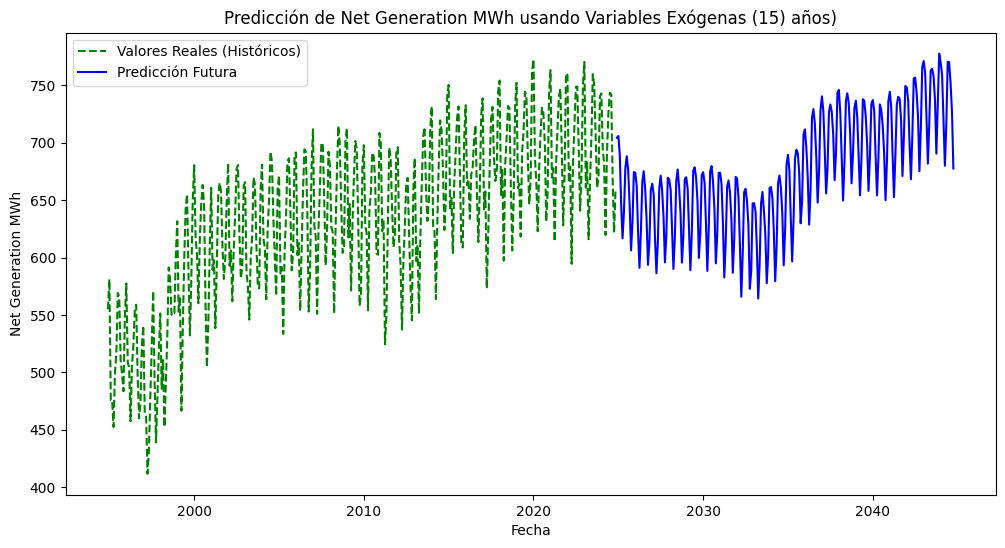

📌 Predicciones futuras de Net Generation MWh:
         Fecha  Predicción
234 2044-06-01  770.334391
235 2044-07-01  770.157811
236 2044-08-01  752.328147
237 2044-09-01  727.008882
238 2044-10-01  677.451283


In [65]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import matplotlib.pyplot as plt

# Seleccionar variables exógenas (X)
X_fc = monthly_data_per_unit[["Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]]

# Seleccionar la variable dependiente (Y)
Y_fc = monthly_data_per_unit["Net_Generation_MWh"]

#Seleccionamos variables X futuro
# Asegurar que X_fc_future tenga el mismo formato que X_fc
X_fc_future = X_future_ridge

años=15

forecaster_ridge = ForecasterDirect(
        regressor=Ridge(),
        steps=años*12,
        lags=np.arange(1,32,1)
        #lags=[6, 12, 24]
)

# Asegurar que las series tengan una frecuencia mensual
X_fc = X_fc.asfreq('MS')
Y_fc = Y_fc.asfreq('MS')
X_fc_future = X_fc_future.asfreq('MS')

# Dividir en entrenamiento y prueba
X_train, X_test = X_fc.iloc[:-36], X_fc.iloc[-36:]  # Últimos 3 años para prueba
Y_train, Y_test = Y_fc.iloc[:-36], Y_fc.iloc[-36:]

# Entrenar el forecaster
forecaster_ridge.fit(y=Y_train,exog=X_train)

# Hacer predicciones en la prueba
Y_pred = forecaster_ridge.predict(steps=len(Y_test), exog=X_test)

# Evaluar el modelo
mae = mean_absolute_error(Y_test, Y_pred)
print(f"MAE en prueba: {mae}")


forecaster_ridge.fit(y=Y_fc,exog=X_fc)


Y_fc_future = forecaster_ridge.predict(steps=años*12, exog=X_fc_future)


# 2️⃣ **Hacer predicciones a futuro usando X_fc_future**
Y_fc_future = model.predict(X_fc_future)

# 3️⃣ **Visualizar la comparación**
plt.figure(figsize=(12, 6))

# Datos históricos
plt.plot(Y_fc.index, Y_fc, label="Valores Reales (Históricos)", linestyle="dashed", color="green")

# Predicciones futuras
plt.plot(X_fc_future.index, Y_fc_future, label="Predicción Futura", color="blue")

plt.xlabel("Fecha")
plt.ylabel("Net Generation MWh")
plt.legend()
plt.title(f"Predicción de Net Generation MWh usando Variables Exógenas ({años}) años)")
plt.show()

# 4️⃣ **Verificar primeros valores de Y_fc_future**
print("📌 Predicciones futuras de Net Generation MWh:")
print(pd.DataFrame({"Fecha": X_fc_future.index, "Predicción": Y_fc_future}).tail())


MAE en prueba: 29.533410662276562


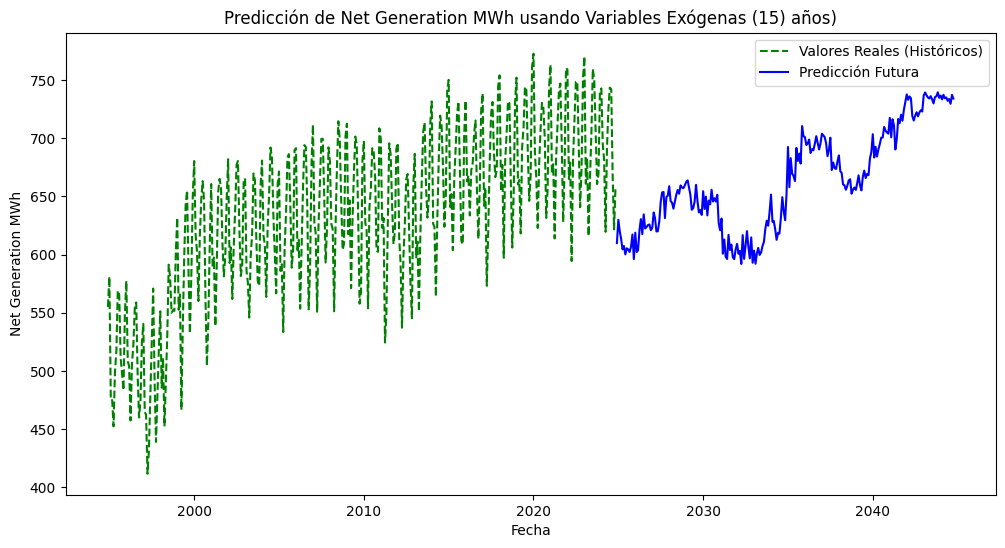

📌 Predicciones futuras de Net Generation MWh:
         Fecha  Predicción
234 2044-06-01  732.132528
235 2044-07-01  733.722338
236 2044-08-01  729.558773
237 2044-09-01  737.269076
238 2044-10-01  734.042815


In [67]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import matplotlib.pyplot as plt

# Seleccionar variables exógenas (X)
X_fc = monthly_data_per_unit[["Capacity_Factor_Percent", "Net_Summer_Capacity_MW"]]

# Seleccionar la variable dependiente (Y)
Y_fc = monthly_data_per_unit["Net_Generation_MWh"]

#Seleccionamos variables X futuro
# Asegurar que X_fc_future tenga el mismo formato que X_fc
X_fc_future = X_future_gb

años=15

forecaster_ridge = ForecasterDirect(
        regressor=GradientBoostingRegressor(),
        steps=años*12,
        lags=np.arange(1,35,1)
        #lags=[6, 12, 24]
)

# Asegurar que las series tengan una frecuencia mensual
X_fc = X_fc.asfreq('MS')
Y_fc = Y_fc.asfreq('MS')
X_fc_future = X_fc_future.asfreq('MS')

# Dividir en entrenamiento y prueba
X_train, X_test = X_fc.iloc[:-36], X_fc.iloc[-36:]  # Últimos 3 años para prueba
Y_train, Y_test = Y_fc.iloc[:-36], Y_fc.iloc[-36:]

# Entrenar el forecaster
forecaster_ridge.fit(y=Y_train,exog=X_train)

# Hacer predicciones en la prueba
Y_pred = forecaster_ridge.predict(steps=len(Y_test), exog=X_test)

# Evaluar el modelo
mae = mean_absolute_error(Y_test, Y_pred)
print(f"MAE en prueba: {mae}")


forecaster_ridge.fit(y=Y_fc,exog=X_fc)


Y_fc_future = forecaster_ridge.predict(steps=años*12, exog=X_fc_future)


# 2️⃣ **Hacer predicciones a futuro usando X_fc_future**
Y_fc_future = model.predict(X_fc_future)

# 3️⃣ **Visualizar la comparación**
plt.figure(figsize=(12, 6))

# Datos históricos
plt.plot(Y_fc.index, Y_fc, label="Valores Reales (Históricos)", linestyle="dashed", color="green")

# Predicciones futuras
plt.plot(X_fc_future.index, Y_fc_future, label="Predicción Futura", color="blue")

plt.xlabel("Fecha")
plt.ylabel("Net Generation MWh")
plt.legend()
plt.title(f"Predicción de Net Generation MWh usando Variables Exógenas ({años}) años)")
plt.show()

# 4️⃣ **Verificar primeros valores de Y_fc_future**
print("📌 Predicciones futuras de Net Generation MWh:")
print(pd.DataFrame({"Fecha": X_fc_future.index, "Predicción": Y_fc_future}).tail())